In [193]:
import xarray as xr
import scipy.io as sio
from scipy.fft import fft, ifft
from matplotlib.path import Path
import pickle
from scipy.stats import pearsonr
from os.path import join
import numpy as np
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
from copy import deepcopy
    
### Specify figure resolution
scale = 1
mpl.rcParams['figure.dpi']        = 150 # set figure resolution (dots per inch) 
mpl.rcParams['hatch.linewidth']   = .15  * scale
mpl.rcParams['axes.labelsize']    = 11  * scale
mpl.rcParams['axes.titlesize']    = 13  * scale
mpl.rcParams['xtick.labelsize']   = 9   * scale
mpl.rcParams['ytick.labelsize']   = 9   * scale
mpl.rcParams['lines.linewidth']   = 1   * scale
mpl.rcParams['legend.fontsize']   = 8   * scale
mpl.rcParams['patch.linewidth']   = 1   * scale
mpl.rcParams['contour.linewidth'] =.5   * scale
mpl.rcParams['axes.labelpad']     = 4 * scale   # space between label and axis
mpl.rcParams['xtick.major.pad']   = 0 * scale   # distance to major tick label in points
mpl.rcParams['ytick.major.pad']   = mpl.rcParams['xtick.major.pad']
mpl.rcParams['lines.markersize']  = 3 * scale

### cartopy-specific parameters
gridline_width                    = .7 * scale
border_width                      = .3 * scale

### manually specified colorbar params
tick_width                        = 0 * scale # controls size of tickmark next to labels
tick_length                       = 2 * scale

$\zeta = \frac{1}{R\cos{\theta}} \Big[\frac{\partial}{\partial\theta}\left(u\cos{\theta}\right)- \frac{\partial v}{\partial \phi}\Big]$, relative vorticity on spherical coordinate

convert coords to polar (i.e. deg 2 rad)

In [194]:
u = xr.open_dataset('gfs.20170728_31.0p25.anl.nc').u.compute()
v = xr.open_dataset('gfs.20170728_31.0p25.anl.nc').v.compute()

lon = deepcopy(u.lon)
lat = deepcopy(u.lat)

theta = np.deg2rad(u.lat)
phi   = np.deg2rad(u.lon)

u['lon'] = phi
v['lon'] = phi

u['lat']  = theta
v['lat']  = theta

u0 = deepcopy(u)
v0 = deepcopy(v)

R = 6.37e6
dv_dphi             = -v0.differentiate('lon')
u_cos_theta         = u0 * np.cos(u0.lat)

dtheta_du_cos_theta = -u_cos_theta.differentiate('lat')
zeta                = 1 / (R*np.cos(u0.lat)) * (dtheta_du_cos_theta - dv_dphi)
zeta = zeta.compute()

$f = 2 \Omega \text{sin}(\theta)$,
planetary vorticity

In [195]:
omega = 7.29e-5 
f = 2*omega * np.sin(u0.lat)

$\eta = \zeta + f$,
absolute vorticity

In [196]:
eta = zeta+f

In [197]:
len(eta.time)

16

In [223]:
# specify a time step
time = eta.time
t = 9
# check the time
time[t]

<xarray.DataArray 'time' ()>
array('2017-07-30T06:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-07-30T06:00:00
Attributes:
    standard_name:  time
    axis:           T

In [228]:
# specify a pressure level
plev = eta.plev
p = 25
# check the pressure level
plev[p]

<xarray.DataArray 'plev' ()>
array(85000.)
Coordinates:
    plev     float64 8.5e+04
Attributes:
    standard_name:  air_pressure
    long_name:      pressure
    units:          Pa
    positive:       down
    axis:           Z

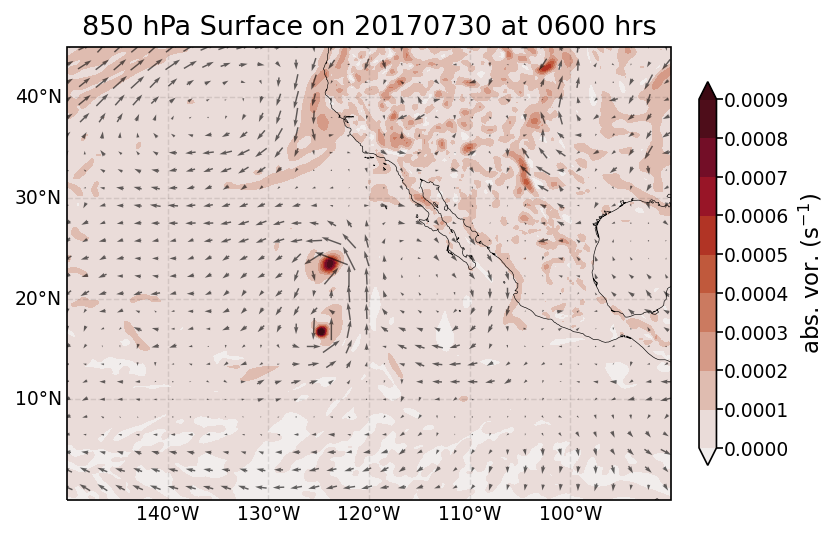

In [248]:
# Plot abs. vor. map of the aforementioned time slice

figsize=(6,4)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([210,270,0,45], crs=ccrs.PlateCarree())
ax.coastlines(linewidth=border_width)
#ax.add_feature(cfeature.BORDERS, zorder=1, linewidth = border_width)
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=.1, linewidth=gridline_width, color='k', zorder=1.05)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': mpl.rcParams['xtick.labelsize']}
gl.ylabel_style = {'size': mpl.rcParams['ytick.labelsize']}

cp1 = ax.contourf(lon,lat, eta.isel(time=t, plev=p),                  
                      extend='both',  cmap='cmo.amp', levels=np.arange(0,10e-4,10e-5),transform=ccrs.PlateCarree())
cb = fig.colorbar(cp1,fraction=0.025, pad=0.04)
cb.set_label("abs. vor. (s$^{-1}$)")

#### Quiver plot
n=7
x,y = np.meshgrid(lon[::n].values, lat[::n].values)
qv = ax.quiver(x,y, u.isel(time=t, plev=p).values[::n,::n], v.isel(time=t, plev=p).values[::n,::n], scale=.5e3,
                   color='black', alpha=.6, transform=ccrs.PlateCarree(), pivot='middle')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("850 hPa Surface on 20170730 at 0600 hrs")
plt.show()

Potential temperature $\theta = T (\frac{P_o}{P})^{R_d/C_p}$

In [73]:
# load temperature data
T = xr.open_dataset('gfs.20170728_31.0p25.anl.nc').t.compute()

In [80]:
RdCp = 0.286
Po = 1000 * 100 # 1000 mbar
Theta = T*(Po/(T.plev)) ** RdCp

In [231]:
# choose a longitudinal step
lonstep = 102
T.lon[lonstep]-360 # see where it is

<xarray.DataArray 'lon' ()>
array(-124.5)
Coordinates:
    lon      float32 235.5

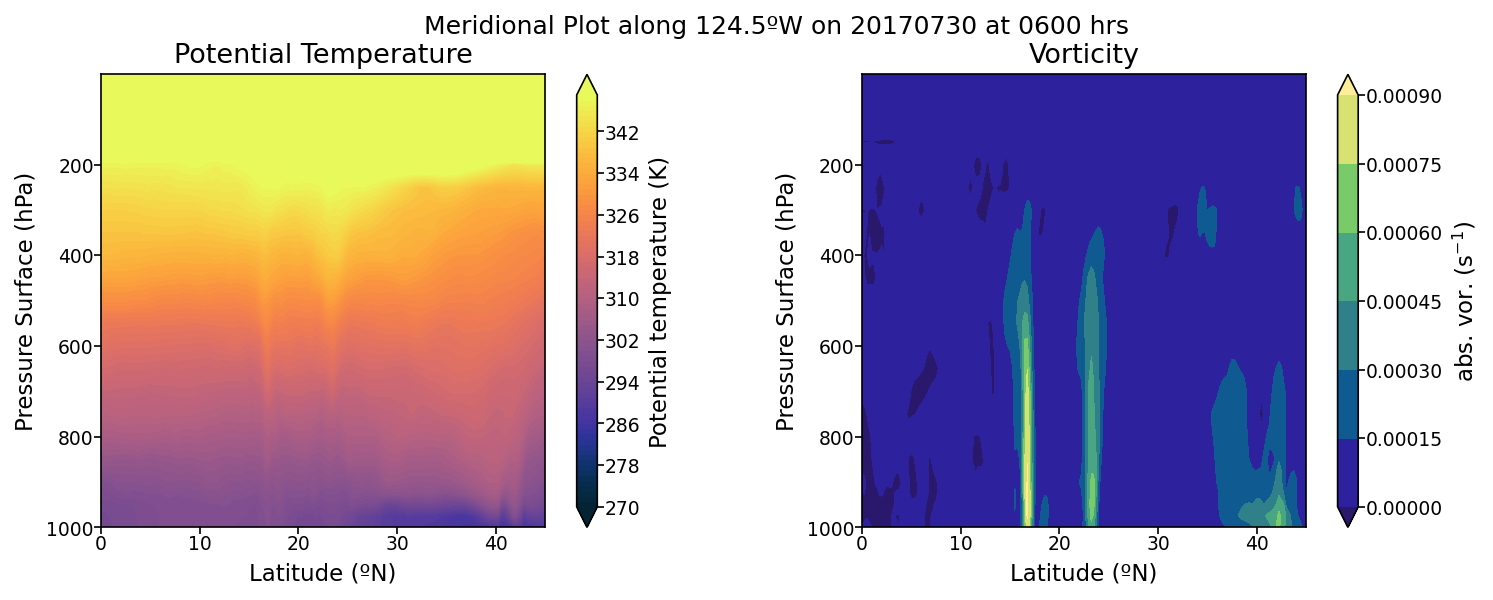

In [249]:
figsize=(12,4)
fig,axs = plt.subplots(1,2,figsize=figsize)

#pcm    = ax.pcolormesh(lat,P,Theta.isel(time=t, lon=120),
                       #edgecolors=None,shading='nearest',
                       #cmap="magma")
#cbar   = fig.colorbar(pcm,ax=ax,fraction=0.025, pad=0.04)

ax1 = axs[0]
cp1 = ax1.contourf(lat,plev/100, Theta.isel(time=t, lon=lonstep),                 
                      extend='both',  cmap='cmo.thermal', levels=np.arange(270,350))
cb = fig.colorbar(cp1,ax=ax1,fraction=0.25)
cb.set_label("Potential temperature (K)")

ax1.invert_yaxis()
ax1.set_xlabel("Latitude (ºN)")
ax1.set_ylabel("Pressure Surface (hPa)")
ax1.set_title("Potential Temperature")

ax2 = axs[1]
cp2 = ax2.contourf(lat,plev/100, eta.isel(time=t, lon=lonstep).T,                 
                      extend='both',  cmap='cmo.haline') #levels=np.arange())
cb = fig.colorbar(cp2,ax=ax2,fraction=0.25)
cb.set_label("abs. vor. (s$^{-1}$)")

ax2.invert_yaxis()
ax2.set_xlabel("Latitude (ºN)")
ax2.set_ylabel("Pressure Surface (hPa)")
ax2.set_title("Vorticity")
plt.suptitle("Meridional Plot along 124.5ºW on 20170730 at 0600 hrs")

plt.show()


END